In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
from collections import deque
import random
import os
import sys
import pathlib
from collections import deque
from tqdm.notebook import tqdm, trange
import datetime
from scipy import interpolate
import math


from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)

In [4]:
from AOE.utils import verbose_print
from AOE.bandit_plots import hit_ratio_analysis, reward_distribution_analysis, regret_plots
from AOE.gp_bandit_finance import gp_bandit_finance
from AOE.mtgp_bandit_finance import mtgp_bandit_finance
from AOE.plots import rescale_plot
from utils import get_bandit_objects, init_variables, init_dictionaries, plot_distribution_statistic

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [5]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

# Load Data & Signals

In [6]:
asset_name            = "ANONYM"

all_data = pd.read_pickle("ANONYM.pkl")
features = all_data[[s for s in all_data.columns if (('buyPrice' not in s) & ('sellPrice' not in s))]] 

ba_mean = all_data.ba_spread.mean()
print('Average Bid Ask spread : ', ba_mean)
print('All features : \n', list(features.columns))

Average Bid Ask spread :  0.22991509999999998
All features : 
 ['twapPrice', 'S0', 'ST', 'mid_price', 'ask_1', 'bid_1', 'IMB', 'ba_spread', 'bid_volume_1', 'ask_volume_1', 'MACD']


# Signals and Bandit objects

In [7]:
strategies  = {'IMB' : {'name'             : 'IMB',
                        'params'           : {'feature_name'     : 'IMB'},
                        'contextual_params': {'feature_name'     : 'IMB', 
                                              'round'            : 1}},

               'MACD' :  {'name'             : 'MACD',
                          'params'           : {'feature_name'     : 'MACD'},
                          'contextual_params': {'feature_name'     : 'MACD', 
                                                'round'            : 1}}}

list_strategies = list(strategies.keys())

d_lrstats, d_taus, d_delta_IIs, d_noises, d_lengthscales, d_correls, b_objs =\
                init_dictionaries( strategies)

# Strategic Layer

In [8]:
def alpha(gamma, sigma, V, nu, dt):
    cosh_alpha_dt = 1 + (gamma * V * (dt*sigma)**2) / (4 * nu)
    return (1/dt) * np.arccosh(cosh_alpha_dt)

def q_star(x, q0, T, gamma, sigma, V, nu, dt):
    alpha_ = alpha(gamma, sigma, V, nu, dt)
    return q0 * np.sinh(alpha_*(T - x))/np.sinh(alpha_*T)

T         = 10/60/24 # 10 minutes
timesteps = np.linspace(0, T, 100)
q0        = 100
S0        = 100
dt        = T/100

# Trading simulation with speculative layer

In [9]:
verbose_level             = 0 # set to 1 for all calculation details

'''
*****************************************
 variables for historical trading data
*****************************************
'''
i_order                   = 0
nb_added_rewards          = {bandit_k:0 for bandit_k in b_objs.keys()}
arrival_intensity         = 0.5
ref_price                 = 'twapPrice' #'S0' #twapPrice ST
nb_orders                 = 0

In [10]:
torch.manual_seed(99)

************************************ Simul number: 9


,count,mean,std,sharpe
oracle,10.0,1.283996,1.235575,1.039189
MTGP_LR,10.0,0.327121,0.682609,0.479222
GP_LR,10.0,0.224909,1.079010,0.208440
GP,10.0,0.222735,0.978201,0.227698
GREEDY,10.0,0.142270,0.610475,0.233049
IMB,10.0,0.074854,0.849826,0.088082
UCB,10.0,0.046583,0.682430,0.068260
MACD,10.0,-0.142617,0.756793,-0.188450
RANDOM,10.0,-0.149142,0.697376,-0.213861


RANDOM : -3.06 bps
GREEDY : 2.92 bps
UCB : 0.96 bps
GP : 4.58 bps
GP_LR : 4.62 bps
MTGP_LR : 6.72 bps


/var/folders/h3/cyxpytps41d3jmsv99t0x7ww0000gn/T/ipykernel_46573/3942383628.py:200: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  for ax in (ax1, ax2, ax3): ax.grid(axis='both'); ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='right')
/var/folders/h3/cyxpytps41d3jmsv99t0x7ww0000gn/T/ipykernel_46573/3942383628.py:200: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  for ax in (ax1, ax2, ax3): ax.grid(axis='both'); ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='right')
/var/folders/h3/cyxpytps41d3jmsv99t0x7ww0000gn/T/ipykernel_46573/3942383628.py:200: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  for ax in (ax1, ax2, ax3): ax.grid(axis='both'); ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='right')


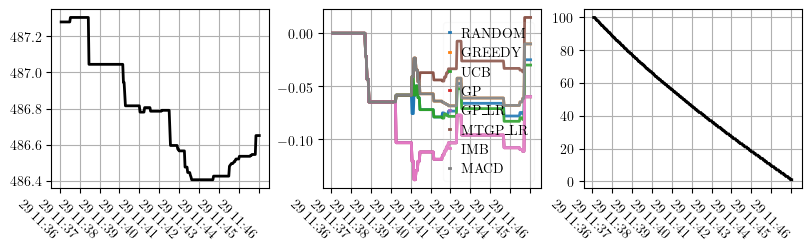

In [11]:
nb_simulations    = 10 # change number for better estimation
res_simulations   = {}
programme_horizon = '10min'

i_starts = np.sort([int(i_start) for i_start in np.random.rand(nb_simulations)*(9*len(all_data)/10)])
buysells          = 2*np.random.randint(0, 2, size=nb_simulations, dtype=int)-1

for (i_simul, i_start, buysell) in zip(range(nb_simulations), i_starts, buysells):
    # choose a random starting point for the programme starting time
    programme_data = all_data.iloc[i_start:].first(programme_horizon)
    
    # Fill na exec prices accordingly
    for col in programme_data.columns:
        if 'Price_' in col:
            programme_data[col].fillna(programme_data[ref_price], inplace=True)
    
    # This also create new bandit objects
    bandit_rewards, bandits_fin_info, batch_times, bandits =\
                init_variables(programme_data,  strategies)
    
    verbose_print(verbose_level, None, f'I received an order at {None} with quantity {buysell}', True)
    
    q0     = 100*buysell
    q      = np.zeros(len(batch_times)+1)
    q[0]   = q0
    dt     = T/len(batch_times)
    
    # try:
    if True:
        for (i_time, batch_time) in enumerate(batch_times):

            sigma       = 5
            q_cible     = q_star(T * i_time/len(batch_times), q0, T, 10**-3, 5, 1.5e7, 10, dt)
            trade_size  = int(q_cible - q[i_time])
            q[i_time+1] = q[i_time]+trade_size
            V           = 15000000 

            nb_orders   += 1
            trade_date = str(batch_time).split(' ')[0]

            ###############################################
            # retrain GPs hyperparameters every N orders 
            ###############################################
            retrain_hyperparameters = True

            ##################################################
            # if an order arrives: decide if buy & sell
            ##################################################
            i_order          += 1

            ######################
            # get feature values
            ######################
            feature_values = features.loc[batch_time, :]

            ######################################
            # select the strategy for all bandits
            ######################################
            verbose_print(verbose_level, batch_time, f'Selecting strategies ...')
            best_strategies_bandits = {}
            for bandit_k in bandits.keys():
                verbose_print(verbose_level, batch_time, f'** Bandit {bandit_k}: Selecting strategies ...')
                if i_time < 5*len(strategies): # at least 5 rewards before sampling
                    best_strategies_bandits[bandit_k]  = random.choice(list(strategies.keys()))
                else:
                    best_strategies_bandits[bandit_k]  = bandits[bandit_k].select_best_strategy(feature_values)
                verbose_print(verbose_level, batch_time, f'Selected strategy: {best_strategies_bandits[bandit_k]}')
                
                bandits_fin_info[bandit_k].loc[batch_time, 'best_strat']  = best_strategies_bandits[bandit_k]

            ######################################
            # Update & Retrain the GPs
            # & Non stationarity test
            ######################################
            tmp_pnls = {bandit_k:np.nan for bandit_k in bandits.keys()}

            for bandit_k in bandits.keys():
                if buysell == 1:
                    tmp_pnls[bandit_k] = -programme_data.loc[batch_time, f'buyPrice_{best_strategies_bandits[bandit_k]}'] + \
                                programme_data.loc[batch_time, ref_price]
                else:
                    tmp_pnls[bandit_k] = programme_data.loc[batch_time, f'sellPrice_{best_strategies_bandits[bandit_k]}'] - \
                                programme_data.loc[batch_time, ref_price]

            for bandit_k in bandits.keys():
                #print('Adding bandit : ', bandit_k, 'values are:', feature_values.MR, best_strategies_bandits[bandit_k], tmp_pnls[bandit_k])
                try:
                    bandits[bandit_k].update_data(features  = feature_values, 
                                                  strat     = best_strategies_bandits[bandit_k], 
                                                  reward    = tmp_pnls[bandit_k], #/ programme_data.loc[batch_time, 'ba_spread'],
                                                  retrain_hyperparameters = retrain_hyperparameters)
                except Exception as e:
                    retrain_hyperparameters = True
                    print('Error while updating the bandit ', bandit_k ,': ', str(e), '\n', tmp_pnls[bandit_k])
                    bandits[bandit_k].update_data(features  = feature_values, 
                                                  strat     = best_strategies_bandits[bandit_k], 
                                                  reward    = tmp_pnls[bandit_k], #/ programme_data.loc[batch_time, 'ba_spread'],
                                                  retrain_hyperparameters = False)
                    #bandits[bandit_k].strat_gp_dict[best_strategies_bandits[bandit_k]].train()
            
            ######################################
            # Record rewards
            ######################################
            for bandit_k in bandits.keys():
                if buysell == 1:
                    bandits_fin_info[bandit_k].loc[batch_time,'execPrice']  = \
                                    programme_data.loc[batch_time, f'buyPrice_{best_strategies_bandits[bandit_k]}'] 
                else:
                    bandits_fin_info[bandit_k].loc[batch_time,'execPrice']  = \
                                    programme_data.loc[batch_time, f'sellPrice_{best_strategies_bandits[bandit_k]}'] 

                bandit_rewards.loc[batch_time, bandit_k]               = tmp_pnls[bandit_k]
                bandits_fin_info[bandit_k].loc[batch_time,'S0']        = programme_data.loc[batch_time, 'S0'] 
                bandits_fin_info[bandit_k].loc[batch_time,'ST']        = programme_data.loc[batch_time, 'ST'] 
                bandits_fin_info[bandit_k].loc[batch_time,'twapPrice'] = programme_data.loc[batch_time, 'twapPrice'] 

            for strat in strategies.keys():
                if buysell == 1:
                    bandit_rewards.loc[batch_time, strat] = \
                                -programme_data.loc[batch_time, f'buyPrice_{strat}'] + \
                                programme_data.loc[batch_time, ref_price]
                else:
                    bandit_rewards.loc[batch_time, strat] = \
                                programme_data.loc[batch_time, f'sellPrice_{strat}'] - \
                                programme_data.loc[batch_time, ref_price]
            
            ##############################
            # Record oracle info
            ##############################
            oracle_strategy = bandit_rewards.loc[batch_time, strategies.keys()].idxmax() #(pnls_buy.loc[batch_time]).idxmax()
            bandit_rewards.loc[batch_time, 'oracle'] = bandit_rewards.loc[batch_time, f'{oracle_strategy}']
            verbose_print(verbose_level, batch_time, f"Oracle strategy: {oracle_strategy}")
        
        # multiply pnls by trading speed
        v = np.diff(q)
        for i in range(len(bandit_rewards)):
            bandit_rewards.iloc[i,:] = np.abs(v[i]) * bandit_rewards.iloc[i,:]
        
        # Store this simulation's results
        res_simulations[i_simul] = buysell, bandit_rewards, bandits_fin_info, q
        
        # UCB_LR results
        for bandit_name in get_bandit_objects(strategies).keys():
            if 'MTGP_' in bandit_name:
                for strat in strategies.keys():
                    lrstats_ = list(bandits[bandit_name].records['lr_statistic']) # same for all strats    
                    i_strat_ = list_strategies.index(strat)
                    noises_  = list(bandits[bandit_name].records['noise']) # same for all strats
                    d_noises[bandit_name][strat]           += [float(i[i_strat_]) for i in noises_]
                    lengthscales_ = list(bandits[bandit_name].records['lengthscale']) # same for all strats

                    # store the correlation between tasks
                    correls = []
                    for task_covar in bandits[bandit_name].records['task_covar']:
                        __diag = np.sqrt(np.diag(np.diag(task_covar)))
                        __gaid = np.linalg.inv(__diag)
                        __corl = __gaid @ task_covar @ __gaid
                        correls += [__corl[0, 1]]
                    d_correls[bandit_name]     += correls
                    
                    d_lrstats[bandit_name][strat]          += [float(i[0]) for i in lrstats_]
                    d_taus[bandit_name][strat]             += [float(i[1]) for i in lrstats_]
                    d_delta_IIs[bandit_name][strat]        += [float(i[2]) for i in lrstats_]
                    d_lengthscales[bandit_name][strat]     += [float(i) for i in lengthscales_]

        # verbose
        clear_output(wait=True)
        print('************************************ Simul number:', i_simul)
        
        '''
        ************************************
        * Plot the trading programme
        ************************************
        ''' 
        rescale_plot(8, 10, 3)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, constrained_layout=True)

        # plot programme prices
        ax1.plot(programme_data.index, programme_data.mid_price, color='k', lw=2)
        
        # get regrets & rewards
        rewards_to_plot = pd.DataFrame(index=programme_data.index)
        for bandit_k in bandits.keys():
            rewards_to_plot[bandit_k] = np.array(bandit_rewards[bandit_k])
        for (i_strat, strat) in enumerate(strategies.keys()):
            rewards_to_plot[strat]    = np.array(bandit_rewards[strat])
        rewards_to_plot = rewards_to_plot.sort_index()
        ax2.plot(rewards_to_plot.index, rewards_to_plot.dropna().cumsum(), lw=2)
        ax2.legend(list(rewards_to_plot.columns), 
               loc='best', fancybox=True, framealpha=0.1, handlelength=0.1)
        df_sim_results = pd.concat( (res_simulations[i][1].dropna().cumsum().iloc[-1]/ba_mean for i in res_simulations.keys()), axis=1).T
        stats_sim = df_sim_results.describe().T
        stats_sim['sharpe'] = stats_sim['mean'] / stats_sim['std']
        
        # Some printing
        display(stats_sim.sort_values(by='mean', ascending=False).loc[:, ['count', 'mean', 'std', 'sharpe']])
        for bandit_k in bandits.keys():
            print( bandit_k, ':', round(10000 * stats_sim.loc[bandit_k, 'mean']/bandits_fin_info[bandit_k].execPrice.mean(), 2), "bps" )
        ax3.plot(res_simulations[i_simul][1].dropna().index, q[1:], color='k', lw=2) #np.linspace(len(res_simulations[i_simul][1].dropna()), 0, len(res_simulations[i_simul][1].dropna()))
        for ax in (ax1, ax2, ax3): ax.grid(axis='both'); ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='right')
        plt.show()

# Statistics: plots

In [15]:
bandit_name  = 'MTGP_LR'

all_noises           = {}
all_lengthscales     = []

for strat in strategies.keys():
    all_noises[strat]       = []
    
for strat in strategies.keys(): #: #strategies.keys():
    all_noises[strat]       += d_noises[bandit_name][strat]
    all_lengthscales        += d_lengthscales[bandit_name][strat]

all_lrs      = []
all_taus     = []
all_delta_II = []

for strat in strategies.keys(): #: #strategies.keys():
    all_lrs      += d_lrstats[bandit_name][strat]
    all_taus     += d_taus[bandit_name][strat]
    all_delta_II += [s for s in d_delta_IIs[bandit_name][strat]]

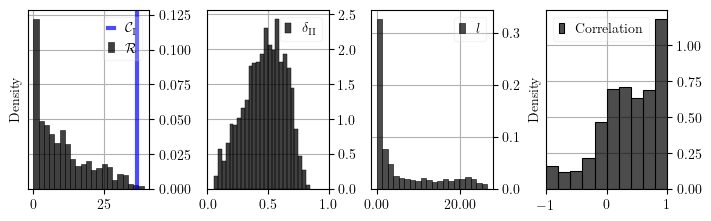

In [18]:
correl_series, all_lrs_, all_taus_ = plot_distribution_statistic(bandit_name, asset_name,
                            all_lrs, all_delta_II, all_lengthscales, all_taus, d_correls)

# Statistics - print

In [19]:
bandit_names = list(res_simulations[0][2].keys())
printed_df   = pd.DataFrame(columns=bandit_names, index=list(res_simulations[0][2][bandit_names[0]].best_strat.unique()))

for bandit_name_ in bandit_names:
    best_strat_counts = res_simulations[0][2][bandit_name_][['best_strat']].value_counts()
    for i_simul in range(1, len(res_simulations)):
        best_strat_counts += res_simulations[i_simul][2][bandit_name_][['best_strat']].value_counts()
    printed_df[bandit_name_] = (100*best_strat_counts/best_strat_counts.sum()).values

print('**** % of actions ****')
display(('$'+printed_df[['MTGP_LR', 'GP_LR', 'GP', 'UCB', 'GREEDY']].round(2).astype(str)+'\%$').loc['IMB', :] +\
        " -- " + ('$'+printed_df[['MTGP_LR', 'GP_LR', 'GP', 'UCB', 'GREEDY']].round(2).astype(str)+'\%$').loc['MACD', :])

all_lrs_temoin = []
for bandit_name_ in bandits.keys():
    if ('MTGP_' in bandit_name_):
        for strat in strategies.keys(): #: #strategies.keys():
            all_lrs_temoin  += d_lrstats[bandit_name_][strat]

all_lrs_temoin_df = pd.DataFrame(all_lrs_temoin).sort_values(by=0)

print('\n**** Correlation ****')
print( '$', np.round(100*np.mean(correl_series), 2),'\%$ ($',  np.round(100*np.std(correl_series), 2),'\%$)')

print('\n**** % of change points ****')
print("$",round(100-100*len(all_lrs_temoin_df[all_lrs_temoin_df < np.mean(all_taus)].dropna())/len(all_lrs_temoin_df), 2),"\%$")

print('\n**** LR statistic - threshold ****')
print( '$', np.round(np.median(all_lrs_), 2),'$ ($',  np.round(np.std(all_lrs_), 2),'$) -- $', np.round(np.median(all_taus_), 2),'$')

print('\n**** delta_II ****')
print( '$', np.round(100*np.mean(all_delta_II), 2),'\%$  ($',  np.round(100*np.std(all_delta_II), 2),'\%$)')

print('\n**** lengthscale ****')
print( '$', np.round(np.median(all_lengthscales), 2),'$ ($',  np.round(np.std(all_lengthscales), 2),'$)')

**** % of actions ****


MTGP_LR      $53.9\%$ -- $46.1\%$
GP_LR      $55.87\%$ -- $44.13\%$
GP         $35.17\%$ -- $64.83\%$
UCB        $49.33\%$ -- $50.67\%$
GREEDY       $40.0\%$ -- $60.0\%$
dtype: object


**** Correlation ****
$ 39.36 \%$ ($ 53.96 \%$)

**** % of change points ****
$ 1.52 \%$

**** LR statistic - threshold ****
$ 8.14 $ ($ 9.63 $) -- $ 36.76 $

**** delta_II ****
$ 47.19 \%$  ($ 16.8 \%$)

**** lengthscale ****
$ 6.91 $ ($ 25.96 $)
